### What patterns are associated with citations resulting from a failure to stop at either a STOP SIGN or RED LIGHT.

#### For this analysis I have narrowed the 'Citations' dataset to only those with a 'Charge Description' of *Fail to Stop at Stop Sign* and *Fail to Stop For Red Signal*.  This results in a total of 2,107 observations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
citations = '''
  select * from [dbo].[spd_PDCitations$]  
  '''
citations = pd.read_sql(citations, connection)
connection.close()

citations['Month'] = citations['Citation Date'].dt.month
citations['Day_of_Month'] = citations['Citation Date'].dt.day

citations['Day_of_Week'] = citations['Citation Date']. \
    apply(lambda x: x.strftime('%a')) #format Citation Day to represent day of week(Mon, Tu, Wed, ect.)

citations['Hour_of_Day'] = citations['Citation Time']. \
    apply(lambda x: str(x)[-7:-4]) # extract the hour of the day from the datetime column
citations['Hour_of_Day'] = pd.to_numeric(citations['Hour_of_Day'],errors='coerce')

#filter for only citations indicative of "failure to stop"
searchfor = [
    'Fail to Stop at Stop Sign',
    'Fail to Stop For Red Signal'
    ]

fail_to_obey = citations[citations['Charge Description'].str.contains('|'.join(searchfor))]

fail_to_obey = fail_to_obey[fail_to_obey['Cited Person Sex'] != 'U'] # remove one instance of person with gender not M or F

In [2]:
fail_to_obey.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,Street,City,State,Zip,District,Beat,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,Month,Day_of_Month,Day_of_Week,Hour_of_Day
11,622046.0,2060090.0,2018-06-22,1630.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1180.0,xxx,E Hualapai DR / N Pima Rd,Scottsdale,AZ,NaN,D4,19.0,3801.0,"Delnero, David",41.0,W,M,U,6,22,Fri,16.0
20,593348.0,8083616.0,2017-10-20,808.0,28-855B,Fail to Stop at Stop Sign,CV,Civil Traffic,874.0,xxx,N Hayden Rd / E Westland DR,Scottsdale,AZ,NaN,D4,20.0,4502.0,"Mendivil, Emilio",26.0,W,M,H,10,20,Fri,8.0
21,593349.0,2045722.0,2017-10-26,441.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1415.0,xxx,E Camelback Rd / N Miller Rd,Scottsdale,AZ,NaN,D2,6.0,906.0,"Shuey, Paul",57.0,W,M,N,10,26,Thu,4.0
39,593367.0,2004416.0,2017-10-19,1515.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1202.0,8xxx,E Chaparral Rd,Scottsdale,AZ,NaN,D2,5.0,1106.0,"Temunovic, Bojan",23.0,W,M,N,10,19,Thu,15.0
61,593392.0,2015969.0,2017-10-19,857.0,28-855B,Fail to Stop at Stop Sign,CV,Civil Traffic,801.0,xxx,E 2nd St / N Marshall Wy,Scottsdale,AZ,NaN,D2,7.0,805.0,"Cortas, Tania",37.0,W,F,N,10,19,Thu,8.0


In [3]:
fail_to_obey_hr_day = fail_to_obey.groupby(['Hour_of_Day', 'Charge Description'])['Charge Description'] \
    .count().unstack().reset_index()

# form data into long(tidy) format, making it easier to graph
fail_to_obey_hr_day_long = pd.melt(fail_to_obey_hr_day, \
                                      id_vars='Hour_of_Day')
fail_to_obey_hr_day_long.head()


,Hour_of_Day,Charge Description,value
0,1.0,Fail to Stop For Red Signal,32
1,2.0,Fail to Stop For Red Signal,23
2,3.0,Fail to Stop For Red Signal,7
3,4.0,Fail to Stop For Red Signal,8
4,5.0,Fail to Stop For Red Signal,8


### Failure to stop at either a STOP SIGN or RED LIGHT distributed throughout the day.

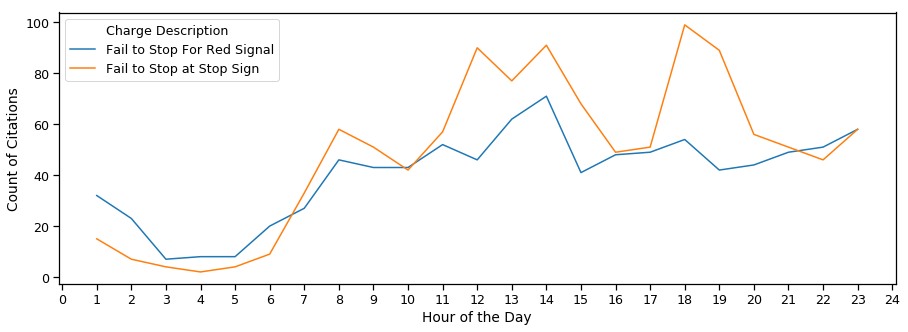

In [23]:
# plt.title("Speeding Citations Throughout the Day",fontsize=20)
# plt.xlabel("Hour of Day",fontsize=14)
# plt.ylabel("Count",fontsize=14)
# plt.tick_params(labelsize=12)
# plt.legend(fontsize=12)


sns.set_context("notebook", font_scale=1.15)

fig = plt.figure(figsize=(15, 5))

ax = sns.lineplot(x="Hour_of_Day", y="value", hue="Charge Description", data=fail_to_obey_hr_day_long)
plt.ylabel("Count of Citations")
plt.xlabel("Hour of the Day")

ax.xaxis.set_major_locator(ticker.MultipleLocator())
plt.savefig('visualizations/Failure to Stop Citations Throughout the Day.png')

### Failure to stop at either a STOP SIGN or RED LIGHT distributed by gender.

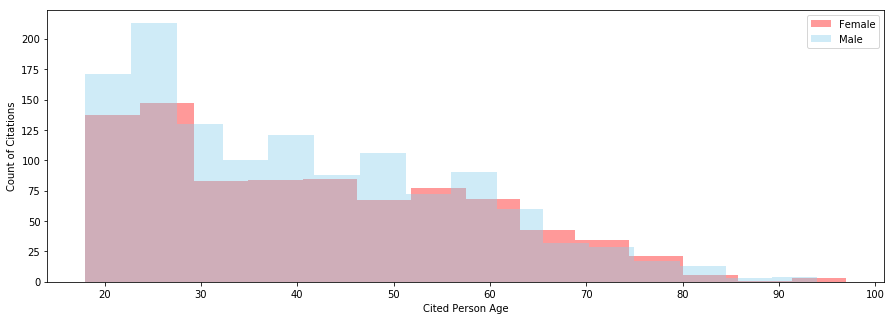

In [17]:
fig = plt.figure(figsize=(15, 5))

sns.distplot(fail_to_obey[fail_to_obey['Cited Person Sex'] == 'F'] \
             .loc[:,'Cited Person Age'], color="red", label="Female", kde=False)

sns.distplot(fail_to_obey[fail_to_obey['Cited Person Sex'] == 'M'] \
             .loc[:,'Cited Person Age'], color="skyblue", label="Male", kde=False)

plt.ylabel("Count of Citations")

plt.legend()

### Failure to stop at either a STOP SIGN or RED LIGHT distributed by gender (Kernel Density Estimation (KDE) plot)

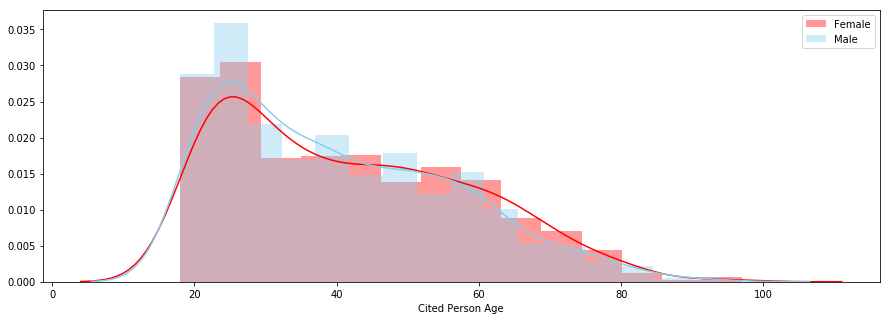

In [18]:
fig = plt.figure(figsize=(15, 5))

sns.distplot(fail_to_obey[fail_to_obey['Cited Person Sex'] == 'F'] \
             .loc[:,'Cited Person Age'], color="red", label="Female")

sns.distplot(fail_to_obey[fail_to_obey['Cited Person Sex'] == 'M'] \
             .loc[:,'Cited Person Age'], color="skyblue", label="Male")

plt.legend()

### While in their 20s and 30s men blow stop signs and stop lights more frequently than women.  However, women blow more stop signs and stop lights than men in their 60s and 70s. 

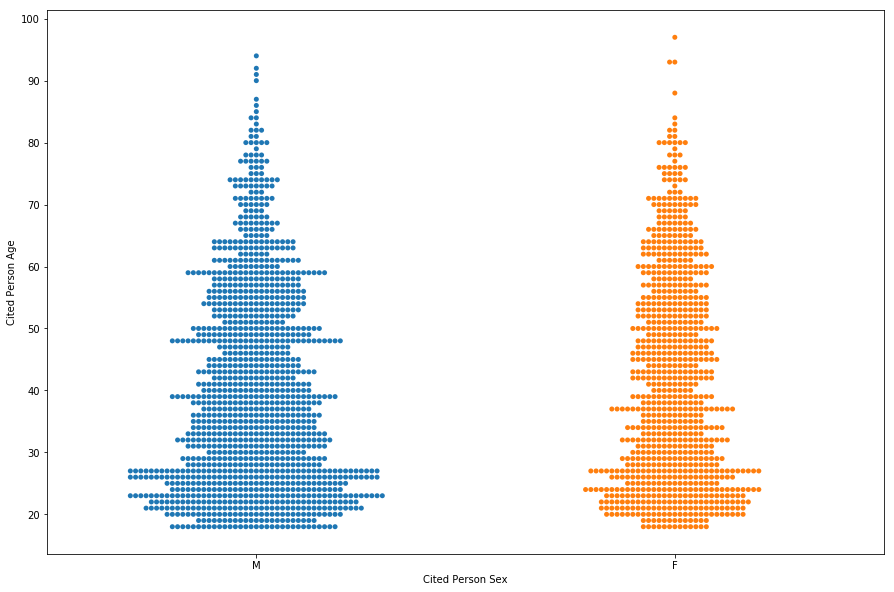

In [19]:
fig = plt.figure(figsize=(15, 10))

sns.swarmplot(x=fail_to_obey['Cited Person Sex'], 
                y=fail_to_obey['Cited Person Age'])

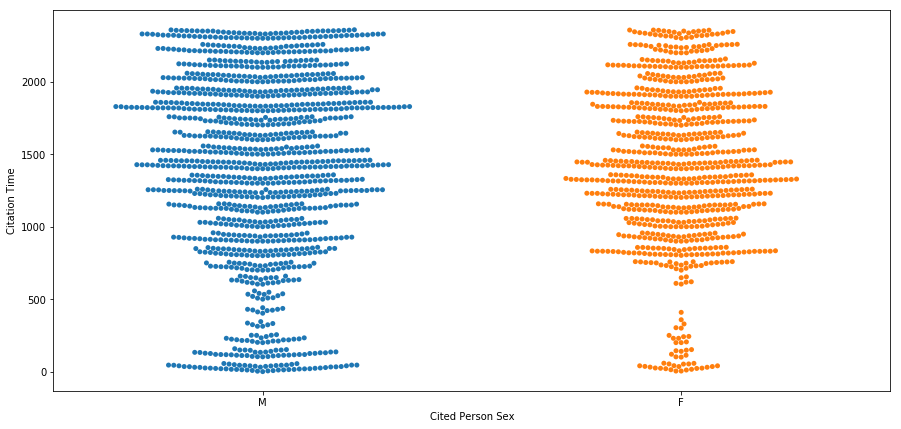

In [6]:
sns.swarmplot(x=fail_to_obey['Cited Person Sex'], 
                y=fail_to_obey['Citation Time'])

### How are stop signs patroled vs. stop lights?

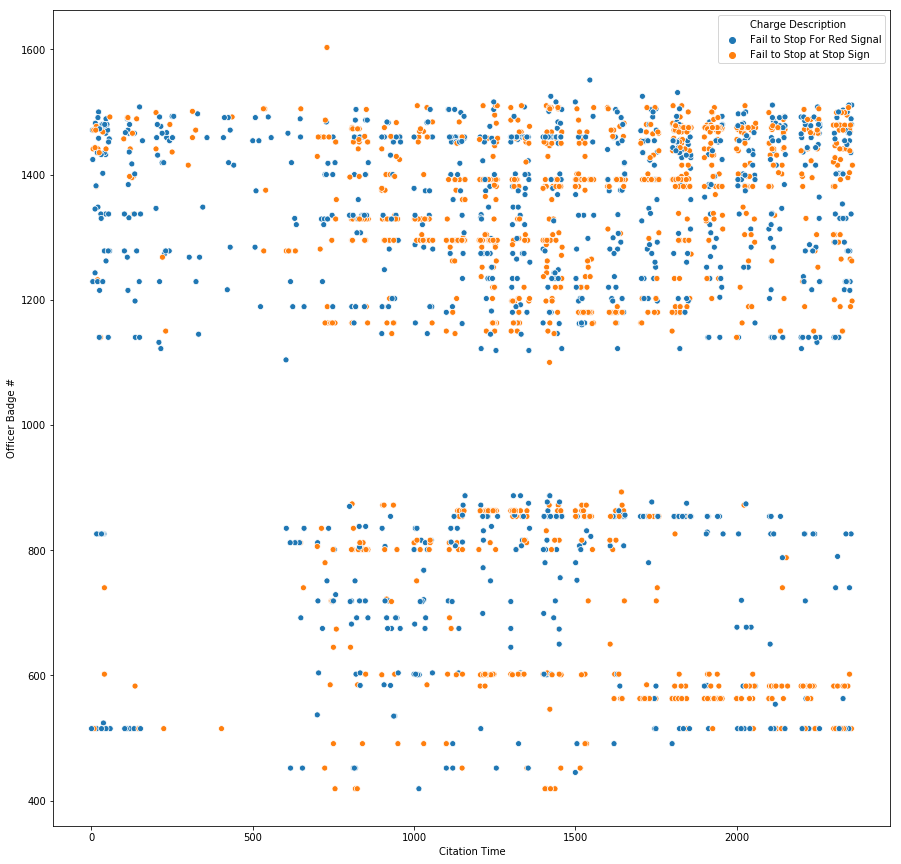

In [7]:
plt.rcParams["figure.figsize"] = [15, 15]
sns.scatterplot(x=fail_to_obey['Citation Time'], 
                y=fail_to_obey['Officer Badge #'], 
                hue=fail_to_obey['Charge Description'])

### Some officers are clearly focused on patrolling stop signs.  Whereas stop lights seem to be enforced by officers in the normal course of business.  There is less of a predictable pattern to the enforcement of stop lights, vs stop signs.